# Reshaping Data with tidyr
## -- DataCamp --

 **Note**

To use this code, select the R environment in Anaconda.
 
 **Used packages**
 - tidyverse
 
**Table of content**
- [&nbsp;&nbsp;1. Tidy data](#toc_041001_1)
- [&nbsp;&nbsp;2. From Wide to Long and Back](#toc_041001_2)
    - [&nbsp;&nbsp;2.1 Wide to Long](#toc_041001_2.1)
    - [&nbsp;&nbsp;2.2 Long to Wide](#toc_041001_2.2)
- [&nbsp;&nbsp;3. Expand data](#toc_041001_3)
- [&nbsp;&nbsp;4. Tidy data](#toc_041001_4)
- [&nbsp;&nbsp;5. Rectangling data](#toc_041001_5)

**Set environment and plot size**

In [1]:
suppressMessages(library(tidyverse))

**Import data**

In [134]:
olympic <- readRDS("data/reshape/olympic_medals_top_10.RDS")
netflix_df <- readRDS("data/reshape/Netflix/netflix_duration.RDS")
star_df <- readRDS("data/reshape/StarWars/star_wars_movie_planet_list.RDS")
nuke <- readRDS("data/reshape/Nuclear/nuke_wide_country.RDS")

<a name="toc_041001_1"></a>
## 1.   Tidy data

The **tidy data** format has columns, rows, and cells, just like in a spreadsheet. There are three conditions:
- Each column should hold a single variable (e.g. City). 
- Each row should hold a single observation. 
- Each cell should now hold a single value (e.g. "Hungary" or "Budapest", not "Hungary, Budapest").

The `dplyr` package works best on data that's already in a tidy format, but unfortunately, most data in the wild is messy. The `tidyr` package will help you deal with this. Useful function to create a tidy dataset:
- `separate()` - separates each cell into several columns along a `sep = ` parameter.
- `separate_rows()` - Separate each cell in a column into several rows.
- `unite()` - does the opposite, it collapse cells across several columns into a single column.

<u>Separate columns</u>

In [11]:
population_df <- tibble(
    country = c("Brazil, South America", 
              "Nepal, Asia",
              "Senegal, Africa",
              "Australia, Oceania"),
    population = c(210, 28.1, 15.8, 25.0)
)
population_df

country,population
<chr>,<dbl>
"Brazil, South America",210.0
"Nepal, Asia",28.1
"Senegal, Africa",15.8
"Australia, Oceania",25.0


☝️ This is a messy dataset. Let's fix it!

In [8]:
population_df %>%
  separate(country, into = c("country", "continent"), sep = ", ")

country,continent,population
<chr>,<chr>,<dbl>
Brazil,South America,210.0
Nepal,Asia,28.1
Senegal,Africa,15.8
Australia,Oceania,25.0


☝️ We got a tidy dataset

In [18]:
head(netflix_df, 3)

title,type,duration
<chr>,<chr>,<chr>
Article 15,Movie,125 min
Kill Me If You Dare,Movie,100 min
The Spy,TV Show,1 Season


In [19]:
netflix_df %>%
  separate(duration, into = c("value", "unit"), sep = " ", convert = TRUE) %>% # convert = TRUE converted value to integer
  head(3)

title,type,value,unit
<chr>,<chr>,<int>,<chr>
Article 15,Movie,125,min
Kill Me If You Dare,Movie,100,min
The Spy,TV Show,1,Season


However, what if our data looks like this:
<div style="text-align:center;">
  <img src="images/reshape_02.png" width = "300" align="center">
</div>

Like the Netflix movie `duration` column, the `ingredients` column has multiple values in a single cell. Only this time, the different values don't correspond to different variables like they did in the Netflix data. Instead, they are different observations of ingredients for a certain drink and should be put in different rows. Note that this allows us to deal with different numbers of ingredients per drink elegantly.

<div style="text-align:center;">
  <img src="images/reshape_01.png" width = "600" align="center">
</div>

We can achieve this result with the `separate_rows()` function. We pass it the messy column name and a string to use as a separator.

In [38]:
drink_df <- tibble (
    drink = c("Chocolate milk", "Orange juice"),
    ingredients = c("milk, chocolate, sugar", "oranges, sugar")    
    )

drink_df %>%
  separate_rows(ingredients, sep = ", ")

drink,ingredients
<chr>,<chr>
Chocolate milk,milk
Chocolate milk,chocolate
Chocolate milk,sugar
Orange juice,oranges
Orange juice,sugar


<u>Unite columns</u>

In [33]:
mydf <- tibble(given_name = c("Adam", "Sarah", "Claire"),
               family_name = c("Smith", "Johnson", "Taylor"))

In [36]:
mydf %>% 
  unite("name", given_name, family_name, sep = " ")

name
<chr>
Adam Smith
Sarah Johnson
Claire Taylor


<a name="toc_041001_2"></a>
## 2. From Wide to Long and Back

<a name="toc_041001_2.1"></a>
**2.1 Wide to long**

Here we want to get a longer data frame, with appropriate column headers and a single variable per column.

<div style="text-align:center;">
  <img src="images/reshape_03.png" width = "600" align="center">
</div>

We can do this with `pivot_longer()`. Some useful arguments:
- `names_to` - name of the new column with the column names. Special case: `.value` separates the string by the `names_sep` character
- `values_to` - name of the new column with the values
- `values_drop_na` - drop rows where the value is NA
- `names_prefix` - deletes prefixes when the original column names contained them
- `names_sep` - we can separate one name column into two by specifying the separator character (e.g. separate column Part1_Group2 into Part and Group columns)
- `names_transform = list(var = as.integer)` - specify the format of the new column

In [43]:
head(nuke, 2)

year,United States,Russian Federation,United Kingdom,France,China,India,Pakistan,North Korea
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1945,3,NA,NA,NA,NA,NA,NA,NA
1946,2,NA,NA,NA,NA,NA,NA,NA


We can achieve our goal, with the `pivot_longer()` function. We've passed it a single argument, a range with the columns to put in a single column. A range is created by specifying the leftmost column followed by a `:` and then the rightmost column. 

Note that we should used backticks ($`$) around the column names that are not character strings, but e.g. numbers!

In [49]:
nuke %>%
  pivot_longer("United States":"North Korea") %>%
  head(2)

year,name,value
<dbl>,<chr>,<int>
1945,United States,3
1945,Russian Federation,NA


Alternatively, we can specify just the columns <u>not to pivot</u> with a minus (`-`) sign. 

In [50]:
nuke %>%
  pivot_longer(-year) %>%
  head(2)

year,name,value
<dbl>,<chr>,<int>
1945,United States,3
1945,Russian Federation,NA


☝️ same result

To overwrite the default column names, we can use the `names_to` and the `values_to` arguments:

In [58]:
nuke %>%
  pivot_longer(-year, names_to = "country", values_to = "n_bombs") %>%
  head(2)

year,country,n_bombs
<dbl>,<chr>,<int>
1945,United States,3
1945,Russian Federation,NA


If we don't want any missing values, we can set `values_drop_na = TRUE`:

In [56]:
nuke %>%
  pivot_longer(-year, names_to = "country", values_to = "n_bombs", 
               values_drop_na = TRUE) %>%
  head(2)

year,country,n_bombs
<dbl>,<chr>,<int>
1945,United States,3
1946,United States,2


Wide datasets sometimes contain column names with prefixes (Like `name_` in the example below)

<div style="text-align:center;">
  <img src="images/reshape_04.png" width = "400" align="center">
</div>

We can remove this prefix when using `pivot_longer()` with the argument `names_prefix =`. So in the new `id` column, `1` and `2` will appear instead of `name_1` and `name_2`:

<div style="text-align:center;">
  <img src="images/reshape_05.png" width = "600" align="center">
</div>

In [62]:
apple <- tibble(
 segment = c("iPhone", "Mac"),
 `2019_Q1` = c(52.0, 7.42),  # use " ` " for column names that start with a number
 `2019_Q2` = c(31.0, 5.51))

apple

segment,2019_Q1,2019_Q2
<chr>,<dbl>,<dbl>
iPhone,52.00,31.00
Mac,7.42,5.51


In [65]:
apple %>%
  pivot_longer(2:3, names_to = c("year", "quarter"), values_to = "value", 
               names_sep = "_Q", 
               names_transform = list(year = as.integer, quarter = as.integer))

segment,year,quarter,value
<chr>,<int>,<int>,<dbl>
iPhone,2019,1,52.00
iPhone,2019,2,31.00
Mac,2019,1,7.42
Mac,2019,2,5.51


Sometimes column headers are more complex, like below.

<div style="text-align:center;">
  <img src="images/reshape_06.png" width = "600" align="center">
</div>

We want to create a tidy table like this:

<div style="text-align:center;">
  <img src="images/reshape_07.png" width = "600" align="center">
</div>

Through the `.value` argument, we can tell the  `pivot_longer()` function  that it should create column names from each string it finds in the second part of the input string after separating by the character specified in the `names_sep` argument (here an underscore). 

<div style="text-align:center;">
  <img src="images/reshape_08.png" width = "400" align="center">
</div>

In [75]:
apple %>%
  pivot_longer(2:3, names_to = c("year", ".value"), 
               names_sep = "_", 
               names_transform = list(year = as.integer, quarter = as.integer))

segment,year,Q1,Q2
<chr>,<int>,<dbl>,<dbl>
iPhone,2019,52.00,31.00
Mac,2019,7.42,5.51


<a name="toc_041001_2.2"></a>
**2.2 Long to wide**

Now we want to achieve the below:

<div style="text-align:center;">
  <img src="images/reshape_09.png" width = "400" align="center">
</div>

We can do this with `pivot_wider()`. Useful arguments:
- `names_from` -  specify the column from which to derive the new column names (above the `metric` column)
- `values_from` - specify where to get the values for these new columns.
- `names_prefix` - prefix for the newly created column names

In [77]:
metric <- tibble(
  country = c("Afghanistan", "Afghanistan", "Albania", "Albania"),
  metric = c("life_exp", "pct_obese","life_exp", "pct_obese"),
  value = c(62.7, 5.5, 76.4, 21.7))

In [80]:
metric %>%
  pivot_wider(names_from = "metric", values_from = "value",
             names_prefix = "new_")

country,new_life_exp,new_pct_obese
<chr>,<dbl>,<dbl>
Afghanistan,62.7,5.5
Albania,76.4,21.7


Sometimes we need to use both `pivot_longer()` and `pivot_wider()` to achieve our goal:

<div style="text-align:center;">
  <img src="images/reshape_10.png" width = "600" align="center">
</div>

<div style="text-align:center;">
  <img src="images/reshape_12.png" width = "600" align="center">
</div>

<div style="text-align:center;">
  <img src="images/reshape_11.png" width = "600" align="center">
</div>

<a name="toc_041001_3"></a>
## 3. Expanding data

The goal is to create new combinations of variables or to identify implicit missing values (combinations of variables not presented in the data)

- `expand_grid()` - creates a tibble with all possible combinations of the vectors that you pass it
- `expand()` - form `tidyr` creates a new tibble with all possible combinations of the values of the listed variables. Drops other variables.
- `complete()` - adds missing possible combinations of values. Fill remaining variables with NA or with custom value. 

<u>The `expand_grid()` function</u>

In [92]:
letters <- c("A", "C", "G", "U")

# Create a tibble with all possible 3 way combinations
codon_df <- expand_grid(
  letter1 = letters,
  letter2 = letters,
  letter3 = letters
)

codon_df %>%  
  unite("codon", letter1:letter3, sep= "") %>% 
  head(3)

codon
<chr>
AAA
AAC
AAG


In [95]:
full_df <-
  expand.grid(
    year = 1945:1946,
    country = c("Russian Federation", "United Kingdom", "United States")
  )

full_df

year,country
<int>,<fct>
1945,Russian Federation
1946,Russian Federation
1945,United Kingdom
1946,United Kingdom
1945,United States
1946,United States


<u>The `expand()` function</u>

In [107]:
incomplete_df <- tibble(
    year = c(1977, 1977, 1979),
    artist = c("Beatles", "Rolling Stones", "Beatles"),
    n_albums = c(2, 1, 1)
    )

incomplete_df

year,artist,n_albums
<dbl>,<chr>,<dbl>
1977,Beatles,2
1977,Rolling Stones,1
1979,Beatles,1


In [108]:

incomplete_df %>%
  expand(year, artist)

year,artist
<dbl>,<chr>
1977,Beatles
1977,Rolling Stones
1979,Beatles
1979,Rolling Stones


☝️ Missing cases were added, `n_albums` was dropped.

<u>The `complete()` function</u>

In [109]:
incomplete_df %>%
  complete(year, artist)

year,artist,n_albums
<dbl>,<chr>,<dbl>
1977,Beatles,2
1977,Rolling Stones,1
1979,Beatles,1
1979,Rolling Stones,NA


☝️ Missing cases were added, `n_albums` was replaced with NA where missing.

In [111]:
incomplete_df %>%
  complete(year, artist, fill = list(n_albums = 0))

year,artist,n_albums
<dbl>,<chr>,<dbl>
1977,Beatles,2
1977,Rolling Stones,1
1979,Beatles,1
1979,Rolling Stones,0


☝️ Now, `n_albums` was replaced with 0 where missing.

With `complete()`, we can even create new combinations with addig additional categories to our existing variables:

In [114]:
incomplete_df %>%
  complete(year, artist = c("Beatles", "Rolling Stones", "ABBA"))

year,artist,n_albums
<dbl>,<chr>,<dbl>
1977,ABBA,NA
1977,Beatles,2
1977,Rolling Stones,1
1979,ABBA,NA
1979,Beatles,1
1979,Rolling Stones,NA


We can do the same thing for the year variable. We specify a range of years to complete with from 1977 till 1979. 

In [115]:
incomplete_df %>%
  complete(year = 1977:1979)

year,artist,n_albums
<dbl>,<chr>,<dbl>
1977,Beatles,2
1977,Rolling Stones,1
1978,NA,NA
1979,Beatles,1


However, there is a downside to specifying a range of values like this. First, is that you have to manually inspect the data for the lowest and highest value present. Second, is that when you re-use your code on an updated or different dataset, you might get unexpected results!

This is where the `full_seq()` function can help. It will look for the lowest and highest value within the vector you pass it, and will then return a sequence between these two values. The interval between the values in the sequence can be set with the `period` argument. Because it looks for min and max values first, the function is not affected by duplicate values in the input. This allows us to pass it a variable from our data frame, giving us the same range of years that we would have specified manually. Note that we can also apply the `full_seq()` function on dates!

In [116]:
incomplete_df %>%
  complete(year = full_seq(year, period = 1))

year,artist,n_albums
<dbl>,<chr>,<dbl>
1977,Beatles,2
1977,Rolling Stones,1
1978,NA,NA
1979,Beatles,1


☝️ Here we got the same result but now our code is more robust!

Let's see another example:

In [120]:
head(olympic, 2)

name,sport,year,medal,team
<chr>,<chr>,<dbl>,<chr>,<chr>
Edward Battel,Cycling,1896,Bronze,Great Britain
Arthur Charles Blake,Athletics,1896,Silver,United States


In [124]:
olympic %>%
  count(team, year, name = "n_medals") %>%
  head(3)

team,year,n_medals
<chr>,<dbl>,<int>
Australia,1896,2
Australia,1900,5
Australia,1904,4


☝️ Not all countries won medals each year. We need to add thos rows with 0 medals before we can plot the results.

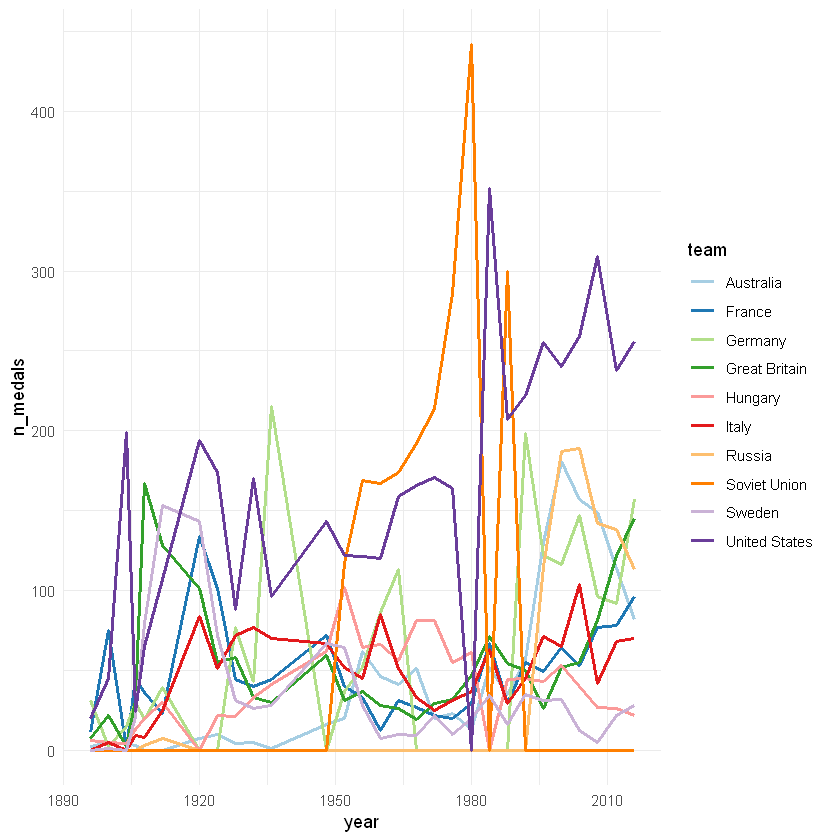

In [127]:
olympic %>%
  count(team, year, name = "n_medals") %>% 
  complete(team, year, fill = list(n_medals = 0)) %>% 
  ggplot(aes(x = year, y = n_medals, color = team)) +
  geom_line(size = 1) +
  scale_color_brewer(palette = "Paired") +
  theme_minimal()

A problem that can arise when using `complete()` is when we pass all variables, we may get nonsensical observations, like below, where  we got observations for the USA on the European continent and the UK in North America. These observations should not have been added since a country is always connected to the same continent.

<div style="text-align:center;">
  <img src="images/reshape_13.png" width = "600" align="center">
</div>

We can establish such a connection with the `nesting()` function. By nesting variables, we tell the `complete()` function to treat them as a single variable! It will then no longer add observations for new value combinations of these variables. The result is better now, with a single observation added for the UK in the forties.

<div style="text-align:center;">
  <img src="images/reshape_14.png" width = "600" align="center">
</div>

Let's move on to a second example. We're looking at data collected by the US National Hurricane Center. It details the start and end dates of tropical storms in the Atlantic. What if we would want to use this data to find out how many storms were active simultaneously over time?

<div style="text-align:center;">
  <img src="images/reshape_17.png" width = "300" align="center">
</div>

To answer this question, we need to take multiple steps. First, we reshape the date with the `pivot_longer()` function to a format with one observation for the start date, and one observation for the end date. What we want to do next, is use the `complete()` function to generate all dates between the start and end dates. Once this is done, we can simply count the dates and we'll have our answer.

However, to achieve this result we first use `group_by()` to group the data by the name of each storm. Only then will the `full_seq()` function use the start and end dates of each storm individually instead of the first and last date in the full dataset. Note that after completing, we ungroup the data to not affect future operations.

<div style="text-align:center;">
  <img src="images/reshape_15.png" width = "600" align="center">
</div>

Now that we have all the dates on which each storm was raging, we can count the occurrences of dates to see how many storms were active simultaneously. We do so with `dplyr`'s `count()` function. After this, we can count the occurrences of dates to see how many storms were active simultaneously. We do so with `count()` function. Finally, we'll use the `complete()` function once more to add zero values for dates on which no storms were active.

<div style="text-align:center;">
  <img src="images/reshape_16.png" width = "600" align="center">
</div>

When we visualize the result, we can clearly see the Atlantic hurricane season starting around July and ending in October each year.

<div style="text-align:center;">
  <img src="images/reshape_18.png" width = "500" align="center">
</div>

<a name="toc_041001_4"></a>
## 4. Rectangling data

In this chapter we will learn how to turn nested data structures such as `JSON` and `XML` files into tidy, rectangular data. This skill will enable us to process data from web `APIs`. 

<a name="toc_041001_4.1"></a>
**4.1 Working with non-rectangular data**

So far, we've always worked with data in a rectangular, or tabular, structure, with columns and rows. To save this kind of data we often use the `CSV` format, where values are separated by commas. While this rectangular format is convenient for our analyses, not all data comes in this shape.

Take for example `JSON` and `XML` files. Both formats are widely used and aim to be both human and machine-readable, but clearly, they don't have a rectangular shape with columns and rows. Instead, they have hierarchical, tree-like structures, with high-level elements branching into lower-level elements. These structures pose a challenge for data analysis, but don't be worried. `tidyr` can help you turn these into a rectangular format.

<div style="text-align:center;">
  <img src="images/reshape_19.png" width = "600" align="center">
</div>

When you read a `JSON` file with the `rjson` package's `fromJSON()` function, you'll end up with a **nested list**. The example shown below has a top-level list with two elements. Each element corresponds to a Star Wars character and contains a named list with two items: the name of the character, and the films they appeared in. This `films` field is in itself again a *list*.

<div style="text-align:center;">
  <img src="images/reshape_20.png" width = "600" align="center">
</div>

As a first step to rectangling this data, we'll use the `tibble()` function to create a data frame with one column, which we'll name character, and pass it the list. You'll see that this data frame already has two rows, one for each top-level element of the input list. However, the values in these rows are lists themselves, whereas we would like to have the elements of these lists spread out over multiple columns.

<div style="text-align:center;">
  <img src="images/reshape_21.png" width = "400" align="center">
</div>

This can be done with tidyr's `unnest_wider()` function. It spreads the two elements of the character list into two columns: name and films. The `unnest_wider()` function was able to come up with these column names because we passed it a named list. 

<div style="text-align:center;">
  <img src="images/reshape_22.png" width = "250" align="center">
</div>

We could take our unnesting one step further and also apply it to our films column, as this too, is a list column. It contains four films for Darth Vader and two for Jar Jar Binks.

<div style="text-align:center;">
  <img src="images/reshape_23.png" width = "600" align="center">
</div>

Since the elements in these columns weren't named lists, `tidyr `had to improvise when creating the column names, and since both characters appeared in a different number of films NA values were added for Jar Jar Binks' 3rd and 4th movie. This data isn't exactly tidy. The problem is that `films` is a variable, and should thus remain in a single column instead of being spread out over several. This is exactly what the `unnest_longer()` function will do for you. We pass it the films variable and the result is a now completely unnested, tidy, data frame. 

<div style="text-align:center;">
  <img src="images/reshape_24.png" width = "250" align="center">
</div>

Rectangling deeply nested data usually comes down to a series of `unnest_longer()` and `unnest_wider()` operations, the order of which depends on the data structure.

In [136]:
star_df

[[1]]
[[1]]$title
[1] "A New Hope"

[[1]]$release_date
[1] "1977-05-25"

[[1]]$planets
[1] "Alderaan" "Yavin IV" "Tatooine"


[[2]]
[[2]]$title
[1] "The Empire Strikes Back"

[[2]]$release_date
[1] "1980-05-17"

[[2]]$planets
[1] "Hoth"        "Dagobah"     "Bespin"      "Ord Mantell"


[[3]]
[[3]]$title
[1] "Return of the Jedi"

[[3]]$release_date
[1] "1983-05-25"

[[3]]$planets
[1] "Dagobah"   "Endor"     "Naboo"     "Coruscant" "Tatooine" 


[[4]]
[[4]]$title
[1] "The Phantom Menace"

[[4]]$release_date
[1] "1999-05-19"

[[4]]$planets
[1] "Naboo"     "Coruscant" "Tatooine" 


[[5]]
[[5]]$title
[1] "Attack of the Clones"

[[5]]$release_date
[1] "2002-05-16"

[[5]]$planets
[1] "Naboo"     "Coruscant" "Kamino"    "Geonosis"  "Tatooine" 


[[6]]
[[6]]$title
[1] "Revenge of the Sith"

[[6]]$release_date
[1] "2005-05-19"

[[6]]$planets
 [1] "Alderaan"       "Dagobah"        "Naboo"          "Coruscant"     
 [5] "Utapau"         "Mustafar"       "Kashyyyk"       "Polis Massa"   
 [9] "Mygeeto"        "Felucia"        "Cato Neimoidia" "Saleucami"     
[13] "Tatooine"      


[[7]]
[[7]]$title
[1] "The Force Awakens"

[[7]]$release_date
[1] "2015-12-11"

[[7]]$planets
[1] "Jakku"

In [142]:
tibble(character = star_df)

character
<list>
"A New Hope, 1977-05-25, Alderaan , Yavin IV , Tatooine"
"The Empire Strikes Back, 1980-05-17 , Hoth , Dagobah , Bespin , Ord Mantell"
"Return of the Jedi, 1983-05-25 , Dagobah , Endor , Naboo , Coruscant , Tatooine"
"The Phantom Menace, 1999-05-19 , Naboo , Coruscant , Tatooine"
"Attack of the Clones, 2002-05-16 , Naboo , Coruscant , Kamino , Geonosis , Tatooine"
"Revenge of the Sith, 2005-05-19 , Alderaan , Dagobah , Naboo , Coruscant , Utapau , Mustafar , Kashyyyk , Polis Massa , Mygeeto , Felucia , Cato Neimoidia , Saleucami , Tatooine"
"The Force Awakens, 2015-12-11 , Jakku"


In [141]:
tibble(character = star_df) %>% 
  unnest_wider(character)

title,release_date,planets
<chr>,<chr>,<list>
A New Hope,1977-05-25,"Alderaan, Yavin IV, Tatooine"
The Empire Strikes Back,1980-05-17,"Hoth , Dagobah , Bespin , Ord Mantell"
Return of the Jedi,1983-05-25,"Dagobah , Endor , Naboo , Coruscant, Tatooine"
The Phantom Menace,1999-05-19,"Naboo , Coruscant, Tatooine"
Attack of the Clones,2002-05-16,"Naboo , Coruscant, Kamino , Geonosis , Tatooine"
Revenge of the Sith,2005-05-19,"Alderaan , Dagobah , Naboo , Coruscant , Utapau , Mustafar , Kashyyyk , Polis Massa , Mygeeto , Felucia , Cato Neimoidia, Saleucami , Tatooine"
The Force Awakens,2015-12-11,Jakku


☝️ Note that `planets` is still a list that we need to unnest but we want to keep its content in one column!

In [145]:
tibble(character = star_df) %>% 
  unnest_wider(character) %>% 
  unnest_longer(planets) %>% 
  head()

title,release_date,planets
<chr>,<chr>,<chr>
A New Hope,1977-05-25,Alderaan
A New Hope,1977-05-25,Yavin IV
A New Hope,1977-05-25,Tatooine
The Empire Strikes Back,1980-05-17,Hoth
The Empire Strikes Back,1980-05-17,Dagobah
The Empire Strikes Back,1980-05-17,Bespin


For more complex lists we may need to unnest over several columns. In the below example, after the first unnesting operation, we see that the rightmost column, `lessons`, is a list column too. However, the lists inside this column are **unnamed lists** and their length varies from three to four. These are signals that we should try using the `unnest_longer(`) function to spread the lesson lists over multiple observations.

<div style="text-align:center;">
  <img src="images/reshape_25.png" width = "500" align="center">
</div>

When we do so, we get 14 observations, one for each lesson in this course. The lessons column is still there as it turned out to be a list of **named lists**. If you are a bit confused at this point, don't worry. Lists columns tend to do that to you. Since the unnested lessons column now contains named lists of equal length, we try the `unnest_wider()` function on it.

<div style="text-align:center;">
  <img src="images/reshape_26.png" width = "500" align="center">
</div>

For each lesson, we now have an `id`, a `title`, and a list of the exercises it contains. We can keep digging deeper by unnesting the exercises over multiple observations with `unnest_longer()`. Note that we used `dplyr's` `select()` function to sub-selected just three columns to keep an overview. We now have 41 observations, one for each exercise in this course.

<div style="text-align:center;">
  <img src="images/reshape_27.png" width = "500" align="center">
</div>


<a name="toc_041001_4.2"></a>
**4.2 Selecting nested variables**

You may not need the data in all the columns you are unnesting, maybe you want to select just a few variables from different layers.

Let's look at a deeply-nested real-world example with JSON data from the Google Maps API. At the top level we have a data frame with city names which we requested location data for, and the JSON response that we got from the API.

<div style="text-align:center;">
  <img src="images/reshape_33.png" width = "250" align="center">
</div>

Using our old approach, we can unnest this JSON data a first time to find another list column. We can keep unnesting this data but as we can see below, the number of columns to keep track of keeps increasing too.

<div style="text-align:center;">
  <img src="images/reshape_34.png" width = "550" align="center">
</div>

Eventually we might just be interested in the coordinates of each city, if we unnest the `geometry` and `location` list columns we can finally access that data. It takes us five unnesting operations and one `select()` call to get this result.

<div style="text-align:center;">
  <img src="images/reshape_32.png" width = "550" align="center">
</div>

Alternatively, we could use `hoist()` to dig into this deeply nested structure directly. We look for elements in the json list column, then select the results list, within this list we select the first element since there only was one, then we select the `geometry` list, the `location list`, and finally either the `latitud` or `longitude` variables. Accessing unnested data this way is more efficient computationally and has a shorter syntax, but it does require you to know the structure of your data perfectly.

<div style="text-align:center;">
  <img src="images/reshape_35.png" width = "400" align="center">
</div>

<a name="toc_041001_4.3"></a>
**4.3 Nesting data for modeling**

Sometimes nested data and the rectangular format can go hand in hand and make your analysis more elegant.

Let's illustrate this with an example. You're looking at a data sample with the numbers of participants and the number of medals won by the USA at the summer and winter Olympics.

<div style="text-align:center;">
  <img src="images/reshape_36.png" width = "400" align="center">
</div>

When we plot this data, we see a positive correlation, the USA wins more medals when more USA athletes participate.

<div style="text-align:center;">
  <img src="images/reshape_37.png" width = "450" align="center">
</div>

Let's say we want to model this pattern, we can use a linear model using the `lm()` function and specify we want to explain the variance in `n_medals` based on `n_participants` plus an intercept of zero, since we know that you'll win zero medals if you don't participate. Don't worry if you're new to modeling, we're just interested in the model output which looks like this. It found a coefficient of 0.463, meaning that for every participant, the USA wins almost half a medal on average. Note that this output is not in a tidy format.

<div style="text-align:center;">
  <img src="images/reshape_38.png" width = "500" align="center">
</div>

It gets worse when we call the `summary()` function on the fitted model. We now get a confusing overview with a lot of text mixed with numbers.

<div style="text-align:center;">
  <img src="images/reshape_39.png" width = "500" align="center">
</div>

This problem can be solved using the `broom` package. Its mission is to turn messy outputs of built-in R functions into tidy tibbles. When we use its `glance()` function on the model, we get a tibble with the model performance statistics. When we use its `tidy()` function, we get an overview of the coefficients estimated by the model, it's just one row in this case and we recognize our earlier result of 0.463.

<div style="text-align:center;">
  <img src="images/reshape_40.png" width = "500" align="center">
</div>

Now let's see how we can plug this trick into a pipeline to train multiple models using nested data. The `nest()` function will nest a subset of a data frame based on some grouping variable, country, in this case. The result is a list column, data, that has tibbles inside.

<div style="text-align:center;">
  <img src="images/reshape_41.png" width = "200" align="center">
</div>

We can now use the `map()` function from the `purrr`package to apply a function to each tibble individually. We tell `map()` to iterate over the data column and to apply a function that fits a linear model on each nested tibble. The result is that we now have a new list column named fit with the fitted linear model.

<div style="text-align:center;">
  <img src="images/reshape_42.png" width = "550" align="center">
</div>

Using `map()` function once more, we can apply `glance()` function on this fitted model. This output too gets added to a list column which we named glanced.

<div style="text-align:center;">
  <img src="images/reshape_43.png" width = "550" align="center">
</div>

The magic happens when we now unnest our model results using `unnest()` function on the glanced column. We get a tidy overview of the model metrics.

<div style="text-align:center;">
  <img src="images/reshape_44.png" width = "550" align="center">
</div>

We can do the same thing for `broom::tidy()` function if we want to inspect the estimated coefficients and more. Let's review what we're doing here. We specify a variable to group by, nest the groups, apply different functions on the nested data using the `map()` function, and then unnest the results.

<div style="text-align:center;">
  <img src="images/reshape_45.png" width = "550" align="center">
</div>

If we now want to create more than one model, all we have to do is add a grouping variable at the start. Here, we've added the season variable to create models for both the winter and summer Olympics. The output remains tidy and it's easy to compare models.

<div style="text-align:center;">
  <img src="images/reshape_46.png" width = "550" align="center">
</div>